In [1]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.utils import to_categorical

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [4]:
from keras.models import load_model

# 원하는 모델 불러오기
model = load_model('/content/drive/MyDrive/Colab Notebooks/0.847.h5')
model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 3s - loss: 0.5456 - acc: 0.8470 - 3s/epoch - 11ms/step


[0.5456118583679199, 0.847000002861023]

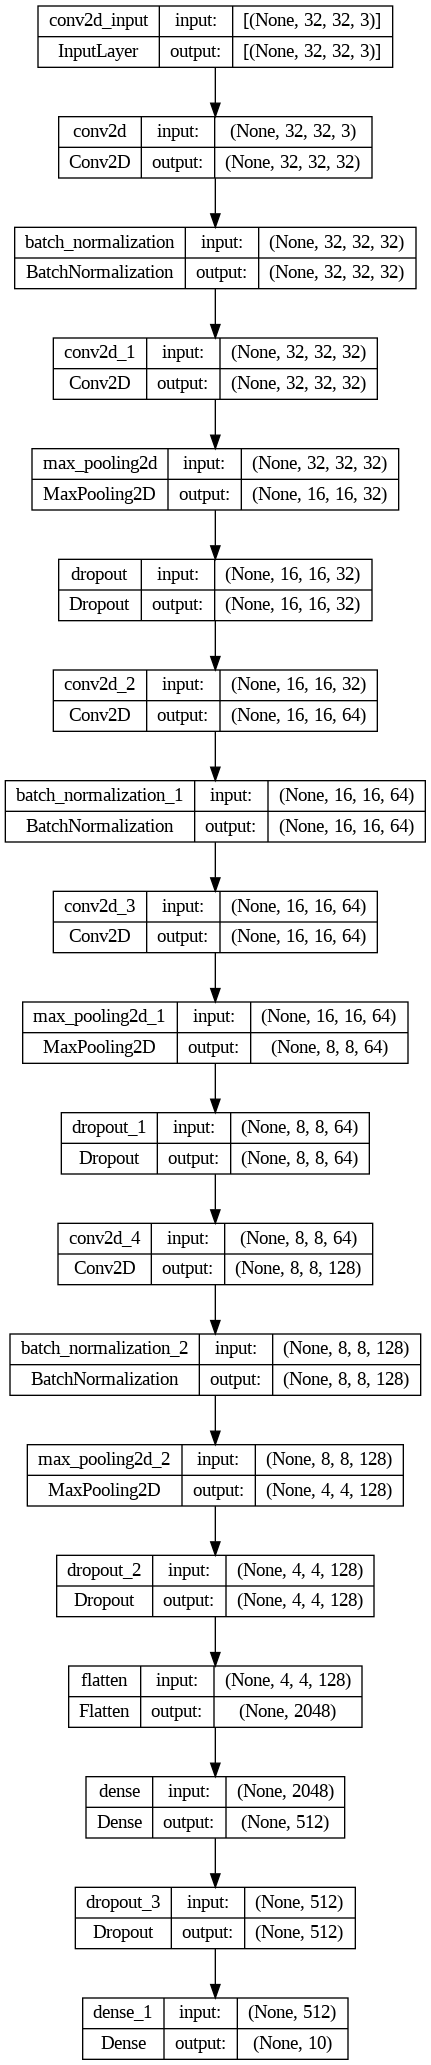

In [5]:
import keras
keras.utils.plot_model(model, show_shapes=True)

<br>
<br>

아래 코드는 주어진 CNN 모델에서 중간 레이어의 출력을 사용하여, 테스트 이미지들의 특징을 2차원으로 시각화하기 위해 t-SNE(t-distributed Stochastic Neighbor Embedding) 알고리즘을 적용한 것입니다. 

여기에서는 먼저 모델이 만들어내는 특징 맵(feature map)을 가져오고, 이를 t-SNE 알고리즘을 이용하여 2차원 플롯에 표현합니다. 

최종 결과를 확인하기 위해 Seaborn의 scatterplot을 사용하며, 각 데이터 포인트의 클래스 레이블을 색상으로 구분합니다.

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_4').output)
intermediate_output = intermediate_model.predict(test_images)

# 차원 축소를 위한 데이터 형태 변경
num_samples, x_shape, y_shape, num_channels = intermediate_output.shape
reshaped_output = np.reshape(intermediate_output, (num_samples, x_shape * y_shape * num_channels))
print(reshaped_output.shape)

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=2)

313/313 [==============================] - 1s 3ms/step
(10000, 8192)


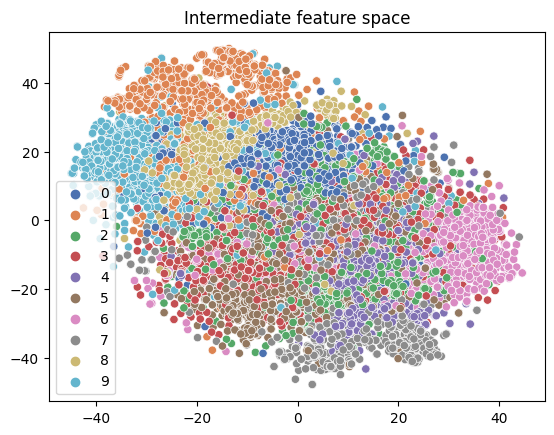

In [7]:
# 전체 시각화 (약 3분 소요)

tsne_output = tsne.fit_transform(reshaped_output)
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=np.argmax(test_labels, axis=1), palette='deep')

plt.title('Intermediate feature space')
plt.show()

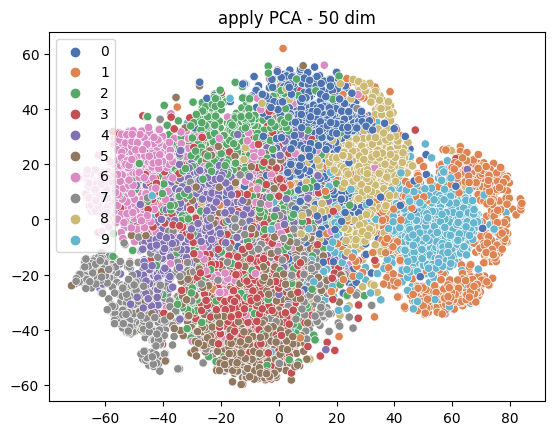

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # 주성분 분석을 이용해 50 차원으로 줄여봅니다.
pca_output = pca.fit_transform(reshaped_output)

tsne_output = tsne.fit_transform(pca_output)
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=np.argmax(test_labels, axis=1), palette='deep')

plt.title('apply PCA - 50 dim')
plt.show()

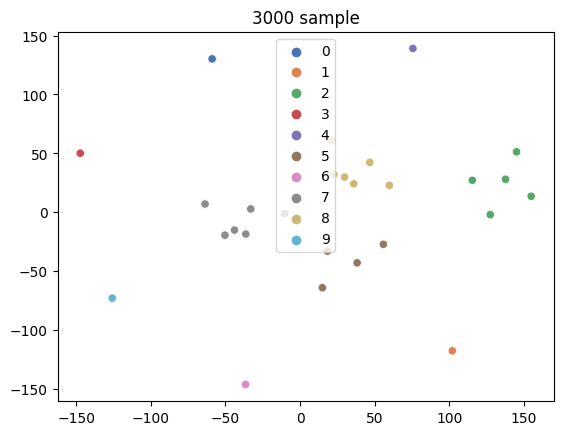

In [9]:
sample_size = 3000  # 샘플 크기를 조절하면 시간을 줄일 수 있습니다. 1~10000
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_labels)
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=np.argmax(sampled_labels, axis=1), palette='deep')

plt.title('3000 sample')
plt.show()

<br>
<br>
<br>

**grad_cam() 함수는 Grad-CAM(Gradient-weighted Class Activation Mapping) 알고리즘을 사용하여 주어진 CNN 모델에서 특정 레이어의 클래스 활성화 맵(Class Activation Map, CAM)을 계산하는 함수입니다.**

### Input:

- `model`: (필수) Convolutional Neural Network(CNN) 관련 테스트 이미지의 인스턴스

- `target_img`: (필수) 해석하려는 이미지를 나타내는 NumPy 배열

- `layer_name`: (필수) Grad-CAM 알고리즘이 히트맵을 계산하는데 사용하는 네트워크 레이어의 이름(예: 'conv2d_4')

- `label_index`: (필수) 원하는 클래스 레이블 인덱스

<br>

### Output : 이미지의 Grad-CAM 히트맵을 반환

<br>

이 함수는 대상 이미지와 특정 레이어에서 모델의 예측 결과를 이용하여 히트맵을 생성하고, 이 히트맵을 사용하여 특정 클래스에 대한 모델의 활성화 영역을 시각화하는 데 도움이 됩니다. 이 함수가 반환하는 히트맵은 이미지에 덧붙여 시각화하거나 분석하는 데 사용할 수 있습니다.

In [10]:
import numpy as np
import cv2
import tensorflow as tf

def grad_cam(model, target_img, layer_name, label_index):
    cls = np.argmax(label_index)
    target_img_tensor = tf.constant(np.expand_dims(target_img, axis=0))

    with tf.GradientTape() as tape:
        inputs = tf.cast(target_img_tensor, tf.float32)
        tape.watch(inputs)
        
        act_map_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
        conv_outputs, predictions = act_map_model(inputs)
        
        loss = predictions[:, cls]

    grads = tape.gradient(loss, conv_outputs)

    if(grads is not None):
        weights = np.mean(grads.numpy(), axis=(1, 2))
    else:
        raise ValueError('Gradient is None. Please check the code.')

    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[1:3])
    for i, w in enumerate(weights[0]):
        cam += w * conv_outputs[0, :, :, i]

    cam = np.maximum(cam, 0)
    max_cam = np.max(cam)
    if max_cam != 0:
        heatmap = cam / max_cam
    else:
        heatmap = cam

    return heatmap

<br>
<br>

**display_multiple_heatmaps() 함수는 여러 개의 이미지에 대해 Grad-CAM 히트맵을 생성하고, 이를 원본 이미지와 함께 그리드 형태로 표시해주는 함수입니다.**

처리 과정:

1. 이미지 인덱스 및 알맞은 파일 경로를 활용하여 이미지와 해당 레이블 인덱스를 가져옴
2. grad_cam() 함수를 사용하여 히트맵 생성
3. 히트맵을 원본 이미지의 크기에 맞게 크기 조정 및 normalization
4. 원본 이미지에 히트맵을 겹쳐서 시각화 이미지 생성
5. 그리드 형태로 원본 이미지와 겹친 이미지를 표시하고, 빈 서브플롯을 숨김
6. 이미지를 출력

<br>

이 함수를 사용하여 여러 이미지의 히트맵을 한 번에 확인하고, 원하는 클래스의 모델 활성화 영역을 시각적으로 분석하고 비교할 수 있습니다. 차례대로 호출된 이미지를 시각적으로 확인할 수 있습니다.

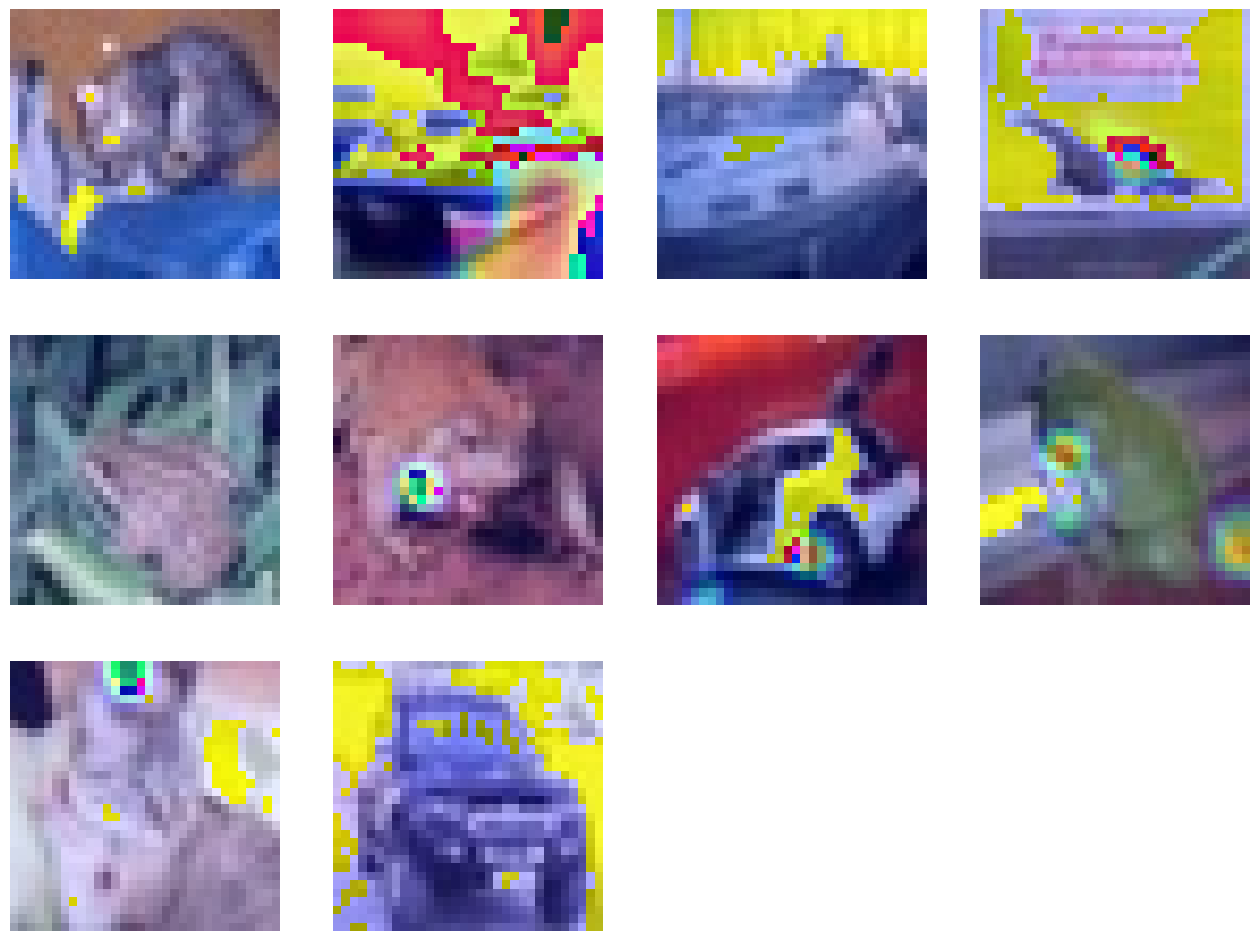

In [11]:
import matplotlib.pyplot as plt

def display_multiple_heatmaps(model, layer_name, test_images, test_labels, image_indices, filepaths):
    n = len(image_indices)
    nrows = int(np.sqrt(n))
    ncols = int(np.ceil(n / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

    for idx, (image_index, filepath) in enumerate(zip(image_indices, filepaths)):
        # 레이블 인덱스 및 이미지 가져오기
        label_index = test_labels[image_index]
        target_img = test_images[image_index]

        # 히트맵 생성하기
        heatmap = grad_cam(model, target_img, layer_name, label_index)
        heatmap_resized = cv2.resize(heatmap, (32, 32))
        heatmap_resized = np.uint8(255 * heatmap_resized)

        # 원본 이미지와 히트맵을 결합
        original_img = cv2.imread(filepath)
        original_img = cv2.resize(original_img, (32, 32))
        superimposed_img = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET) * 0.4 + original_img
        
        ax = axes[idx // ncols, idx % ncols]
        ax.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax.axis('off')
    
    # 빈 서브플롯을 숨김
    for idx in range(n, nrows * ncols):
        axes[idx // ncols, idx % ncols].axis('off')

    plt.show()

# 이미지의 인덱스 및 경로들 설정
image_indices = list(range(10))  # 현재 데이터셋에서 원하는 인덱스를 사용 (현재는 0~9번째 테스트이미지)
filepaths = [f'test_image_{index}.jpg' for index in image_indices]

# 선택한 이미지 저장하기
for i, index in enumerate(image_indices):
    image_array = test_images[index] * 255
    image_array = image_array.astype(np.uint8)
    cv2.imwrite(filepaths[i], cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

# 이 함수를 사용하여 히트맵 표시하기
display_multiple_heatmaps(model, 'conv2d_4', test_images, test_labels, image_indices, filepaths)

**히트맵(Heatmap)은 데이터의 상대적인 크기나 값을 색상의 강도로 나타내어 시각화하는 그래프입니다.** 히트맵은 데이터의 분포와 패턴을 한눈에 파악하기 쉽게 하여, 데이터 분석에 많이 사용됩니다.

Grad-CAM 히트맵에서 사용되는 색상은 일반적으로 JET 컬러맵(colormap)을 따릅니다. JET 컬러맵의 색상 의미는 다음과 같습니다.

- **`파란색`** : 낮은 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 거의 기여하지 않음을 의미합니다. 모델이 이 영역을 해당 클래스와 관련이 거의 없는 것으로 간주합니다.

- **`청록색`** : 낮은 중간 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 약간의 기여를 함을 나타냅니다.

- **`녹색`** : 중간 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 중간 정도의 기여를 내고 있음을 의미합니다.

- **`노란색`** : 높은 중간 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스에 높은 정도의 기여를 내고 있음을 나타냅니다.

- **`빨간색`** : 높은 값. 이 경우, 해당 영역이 CNN 모델에서 주어진 클래스의 확률에 매우 큰 기여를 함을 의미합니다. 이러한 영역은 특히 해당 클래스를 판별하는 데 중요한 부분이며, 모델에 큰 영향을 미칩니다.

<br>

간단히 말해, Grad-CAM 히트맵에서의 색상은 높은 값을 빨간색으로, 낮은 값을 파란색으로 표시하는 방식으로, 각 색상이 CNN 모델에서 특정 클래스에 대한 기여도를 나타냅니다. 이를 통해 모델이 이미지 영역별로 어느 정도 중요하게 여기는지 한눈에 파악할 수 있습니다. 이렇게 시각적으로 분석한 결과를 바탕으로 모델 성능 개선의 방향성을 도출할 수 있습니다.